In [683]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
from pathlib import Path
import seaborn as sns
import csv
import scipy
from scipy import stats
from scipy.optimize import curve_fit
import os
from matplotlib.pyplot import figure


In [719]:
def box_and_whisker(data, title, ylabel, xticklabels, path_to_save_fig):
    """
    Create a box-and-whisker plot with significance bars.
    """
    from matplotlib.pyplot import figure

    figure(figsize=(8, 6), dpi=150)
    ax = plt.axes()
    bp = ax.boxplot(data, widths=0.4, patch_artist=False)
    # for i in range(6):
    #   y = data[i]
    #   x = np.random.normal(1+i, 0.03, size=len(y))
    #   plt.plot(x, y, 'r.', alpha=0.4)
    # Graph title
    ax.set_title(title, fontsize=14)
    # Label y-axis
    ax.set_ylabel(ylabel, fontsize = 12)
    # Label x-axis ticks
    ax.set_xticklabels(xticklabels)
    # Hide x-axis major ticks
    ax.tick_params(axis='x', which='major', length=0, labelsize = 12)
    # Show x-axis minor ticks
    xticks = [0.5] + [x + 0.5 for x in ax.get_xticks()]
    ax.set_xticks(xticks, minor=True)
    # Clean up the appearance
    ax.tick_params(axis='x', which='minor', length=3, width=1)

    # Change the colour of the boxes to Seaborn's 'pastel' palette
    # colors = sns.color_palette('pastel')
    # for patch, color in zip(bp['boxes'], colors):
    #     patch.set_facecolor(color)

    # Colour of the median lines
    plt.setp(bp['medians'], color='r', linewidth = 1.5)

    # Check for statistical significance
    significant_combinations = []
    # Check from the outside pairs of boxes inwards
    ls = list(range(1, len(data) + 1))
    combinations = [(ls[x], ls[x + y]) for y in reversed(ls) for x in range((len(ls) - y))]
    print(combinations)
    for c in combinations:
        data1 = data[c[0] - 1]
        data2 = data[c[1] - 1]
        # Significance
        U, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
        if p < 0.05:
            significant_combinations.append([c, p])
        else: significant_combinations.append([c, 0])

    # Get info about y-axis
    bottom, top = ax.get_ylim()
    yrange = top - bottom

    # Significance bars
    for i, significant_combination in enumerate(significant_combinations):
        # Columns corresponding to the datasets of interest
        x1 = significant_combination[0][0]
        x2 = significant_combination[0][1]
        # What level is this bar among the bars above the plot?
        level = len(significant_combinations) - i
        # Plot the bar
        bar_height = (yrange * 0.08 * level) + top
        bar_tips = bar_height - (yrange * 0.02)
        plt.plot(
            [x1, x1, x2, x2],
            [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k')
        # Significance level
        p = significant_combination[1]
        if p < 0.001 and p > 0:
            sig_symbol = '***'
        elif p < 0.01 and p > 0:
            sig_symbol = '**'
        elif p < 0.05 and p > 0:
            sig_symbol = '*'
        elif p == 0:
            sig_symbol = 'ns'
        text_height = bar_height + (yrange * 0.01)
        plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', c='k')
    print(significant_combinations)
    # Adjust y-axis
    bottom, top = ax.get_ylim()
    yrange = top - bottom
    ax.set_ylim(bottom - 0.02 * yrange, top)

    # Annotate sample size below each box
    # for i, dataset in enumerate(data):
    #     sample_size = len(dataset)
    #     ax.text(i + 1, bottom, fr'n = {sample_size}', ha='center', size='x-small')
    plt.savefig(path_to_save_fig, dpi=150)
    plt.show()

# Function to compute diffusion coefficient and slope

In [433]:
def straightline(x, m, c):
    return m * x + c
    
def msd_track(df, path_msd, path_coef):
    df = df.rename(columns = {'POSITION_X' : 'X', 'POSITION_Y' : 'Y'})
    df['X'] = pd.to_numeric(df['X'], errors='coerce')
    df['Y'] = pd.to_numeric(df['Y'], errors='coerce')
    df['TRACK_ID'] = pd.to_numeric(df['TRACK_ID'], errors='coerce')
    df['FRAME'] = pd.to_numeric(df['FRAME'], errors='coerce')
    

    df = df.dropna(subset=['X', 'Y'])

    id = df['TRACK_ID'].unique()

    # Precompute trajectories
    traj = [np.column_stack((
            df.loc[df['TRACK_ID'] == track_id, 'X'].values, 
            df.loc[df['TRACK_ID'] == track_id, 'Y'].values)) 
        for track_id in id]
    
    # Initialize results
    diffusion_coefs = []

    MSD_all = []
    dx_all = []
    # Compute displacements and related statistics
    for Traj in traj:
        X = Traj[:, 0] * 0.12 
        Y = Traj[:, 1] * 0.12
        Length = len(Traj)
        # print(Length)
        MSD = np.zeros(Length - 1)  # mean squared displacement
        n = np.zeros(Length - 1)  # used to measure number of trajectories of given length for weighting
        tau = np.zeros(Length - 1)  # times between MSDs
        track_lengths = np.zeros(Length - 1)
        dx = []
        dy = []

        for n in range(1, Length):
            # Calculate displacements efficiently
            delta_X = X[n:] - X[:Length - n]
            delta_Y = Y[n:] - Y[:Length - n]

            displacement = delta_X**2 + delta_Y**2   
            MSD[n - 1] = np.mean(displacement)
            track_lengths[n - 1] = len(displacement)
            tau[n - 1] = n * 0.01
            
        tau = tau[: 4]
        MSD = MSD[: 4]
        MSD_all.append(MSD)
        track_lengths = track_lengths[: 4]
        weights = track_lengths[: 4].astype("float32") / float(np.amax(track_lengths[: 4]))
        # plt.plot(tau, MSD)
        # plt.xlabel(r"$\tau$")
        # plt.ylabel("MSD ($\mu$m$^2$)")
        try:
            popt, pcov = curve_fit(straightline, tau, MSD, p0=[1, 0], sigma=weights)
            # if popt[0] > 0:
            diffusion_coefs.append(popt[0] / 4.0)
        except:
            print("WARNING: Unable to fit curve")
        # plt.show()
        
    plt.hist(diffusion_coefs, bins = 50)
    plt.xlabel("Diffusion coefficient ($\mu$m$^{2}$s$^{-1}$)")
    plt.ylabel("Number of foci trajectories")

    # Save values
    msd_df = pd.DataFrame(MSD_all).T
    msd_df.to_csv(path_msd, index = False)
    
    dif_coef = pd.DataFrame(diffusion_coefs)
    dif_coef.to_csv(path_coef, index = False)

<>:75: SyntaxWarning: invalid escape sequence '\m'
<>:75: SyntaxWarning: invalid escape sequence '\m'
/var/folders/x4/mnnq2_xj6tl1_22dfl8_x_qm0000gn/T/ipykernel_5683/127788190.py:75: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("Diffusion coefficient ($\mu$m$^{2}$s$^{-1}$)")


# Compute msd_tracks for your dataset

In [547]:
path = '/Users/lizakozlikina/Desktop/NOSOV dSTORM/SPT/Stats tracks/SNAP25_Prop/SNAP25_Prop_spots_8_wtf.csv'
df = pd.read_csv(path)

df = df.loc[3:, ['TRACK_ID', 'POSITION_X', 'POSITION_Y', 'FRAME']]
df['TRACK_ID'] = pd.to_numeric(df['TRACK_ID'], errors='coerce')
df['FRAME'] = pd.to_numeric(df['FRAME'], errors='coerce')
df = df.sort_values(by = ['FRAME'])
df.dtypes

/var/folders/x4/mnnq2_xj6tl1_22dfl8_x_qm0000gn/T/ipykernel_5683/3091905836.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


TRACK_ID       int64
POSITION_X    object
POSITION_Y    object
FRAME          int64
dtype: object

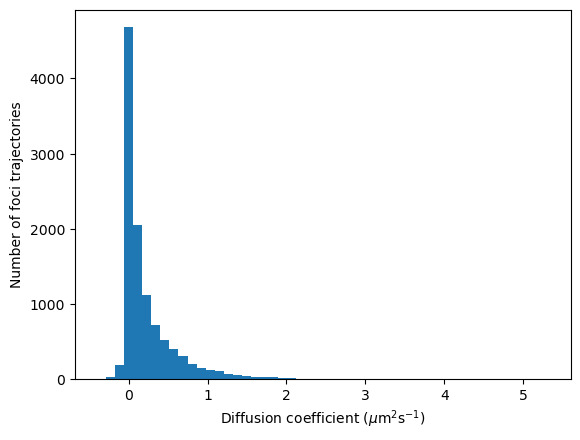

In [551]:
msd_track(df,'/Users/lizakozlikina/Desktop/NOSOV dSTORM/SPT/Stats tracks/SNAP25_Prop/msd_8.csv', '/Users/lizakozlikina/Desktop/NOSOV dSTORM/SPT/Stats tracks/SNAP25_Prop/dif_coef_8.csv')

# Statistics – Mean diffusion coefficient

In [691]:
def values_mean(path_to_vals):
  paths_to_df = []

  for filename in os.listdir(path_to_vals):
    if filename.endswith('csv'):
      f = os.path.join(path_to_vals, filename)
      paths_to_df.append(f)
    else: continue

  mean_vals = []
  for p in paths_to_df:
    df = pd.read_csv(p)
    mean = df['0'].mean()    
    mean_vals.append(mean)      
  DF = pd.DataFrame({'mean' : mean_vals})
  return DF

In [773]:
DF_tent_c = values_mean('/Users/lizakozlikina/Desktop/NOSOV dSTORM/SPT/SNAP25/TeNT Control/control tent 67 prop control')
DF_tent = values_mean('/Users/lizakozlikina/Desktop/NOSOV dSTORM/SPT/SNAP25/TeNT/snap_tent_dif_coef')
DF_prop_c = values_mean('/Users/lizakozlikina/Desktop/NOSOV dSTORM/SPT/SNAP25/SNAP25_Prop_Control/snap_prop_control_dif_coef')
DF_prop = values_mean('/Users/lizakozlikina/Desktop/NOSOV dSTORM/SPT/SNAP25/SNAP25_Prop/snap_prop_dif_coef')

In [775]:
data = [DF_tent_c.iloc[:,0], DF_prop.iloc[:,0], DF_tent.iloc[:,0]]

[(1, 3), (1, 2), (2, 3)]
[[(1, 3), 0], [(1, 2), 0.0042573385489626], [(2, 3), 0.0014457807008947526]]


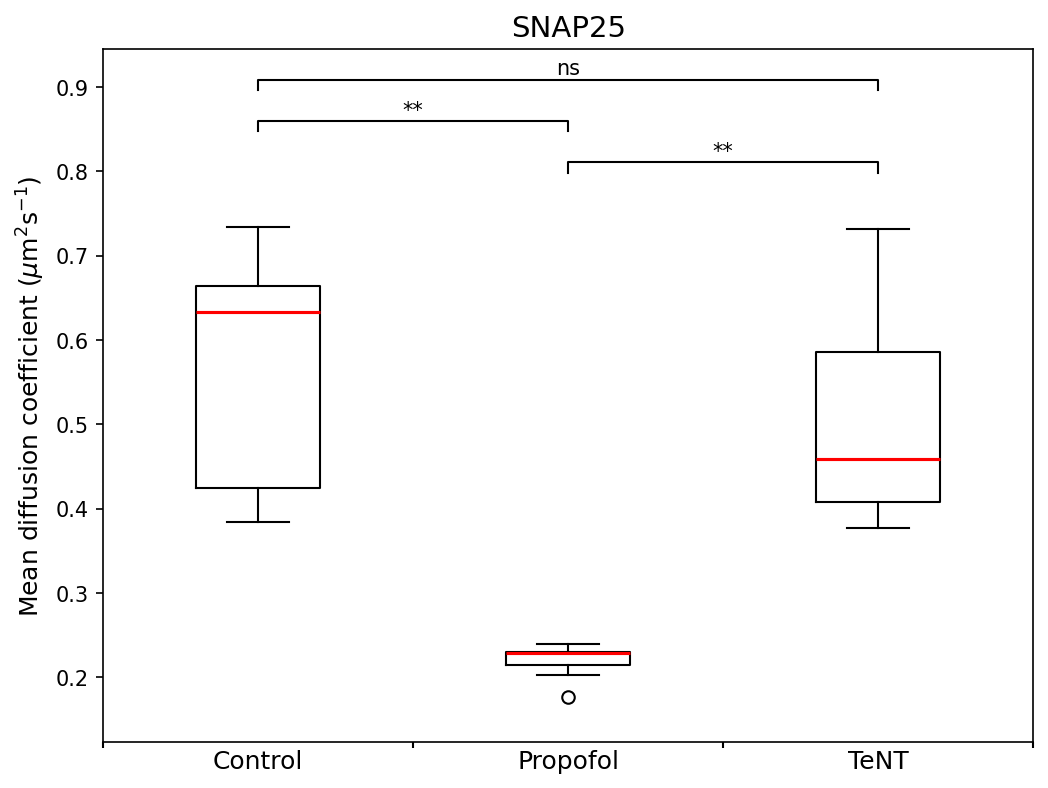

In [777]:
title = 'SNAP25'
ylabel = r'Mean diffusion coefficient ($\mu$m$^{2}$s$^{-1}$)'
xticklabels =['Control', 'Propofol', 'TeNT']
path_to_save_fig = "/Users/lizakozlikina/Desktop/NOSOV dSTORM/SPT/SNAP25/mean_dif_coef_all_filtered_control"

box_and_whisker(data, title, ylabel, xticklabels, path_to_save_fig)

# Statistics – distributions of diffusion coefs

In [685]:
df_prop1 = pd.read_csv('/Users/lizakozlikina/Desktop/NOSOV dSTORM/SPT/SNAP25/SNAP25_Prop/snap_prop_dif_coef/dif_coef_1.csv')
df_prop2 = pd.read_csv('/Users/lizakozlikina/Desktop/NOSOV dSTORM/SPT/SNAP25/SNAP25_Prop/snap_prop_dif_coef/dif_coef_2.csv')

# DF_tent = values_mean_std('/Users/lizakozlikina/Desktop/NOSOV dSTORM/SPT/SNAP25/TeNT/snap_tent_dif_coef')
# DF_prop_c = values_mean_std('/Users/lizakozlikina/Desktop/NOSOV dSTORM/SPT/SNAP25/SNAP25_Prop_Control/snap_prop_control_dif_coef')
# DF_prop = values_mean_std('/Users/lizakozlikina/Desktop/NOSOV dSTORM/SPT/SNAP25/SNAP25_Prop/snap_prop_dif_coef')

<Axes: xlabel='0', ylabel='Count'>

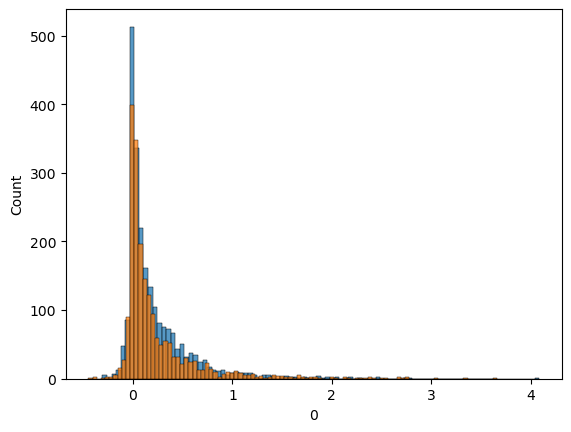

In [687]:
sns.histplot(df_prop1['0'])
sns.histplot(df_prop2['0'])


In [707]:
def histplot_group(path_to_vals, title):
  paths_to_df = []

  for filename in os.listdir(path_to_vals):
    if filename.endswith('csv'):
      f = os.path.join(path_to_vals, filename)
      paths_to_df.append(f)
    else: continue

  mean_vals = []
  for p in paths_to_df:
    df = pd.read_csv(p)
    f = sns.histplot(df['0'])
  f.set_title(title)
  f.set_xlabel("Diffusion coefficient ($\mu$m$^{2}$s$^{-1}$)")
  return f

<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
/var/folders/x4/mnnq2_xj6tl1_22dfl8_x_qm0000gn/T/ipykernel_5683/41933341.py:15: SyntaxWarning: invalid escape sequence '\m'
  f.set_xlabel("Diffusion coefficient ($\mu$m$^{2}$s$^{-1}$)")


<Axes: title={'center': 'Propofol'}, xlabel='Diffusion coefficient ($\\mu$m$^{2}$s$^{-1}$)', ylabel='Count'>

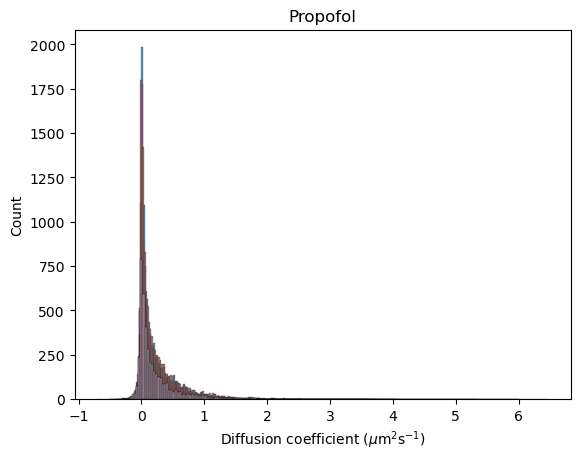

In [709]:
histplot_group('/Users/lizakozlikina/Desktop/NOSOV dSTORM/SPT/SNAP25/SNAP25_Prop/snap_prop_dif_coef', 'Propofol')

<Axes: title={'center': 'TeNT'}, xlabel='Diffusion coefficient ($\\mu$m$^{2}$s$^{-1}$)', ylabel='Count'>

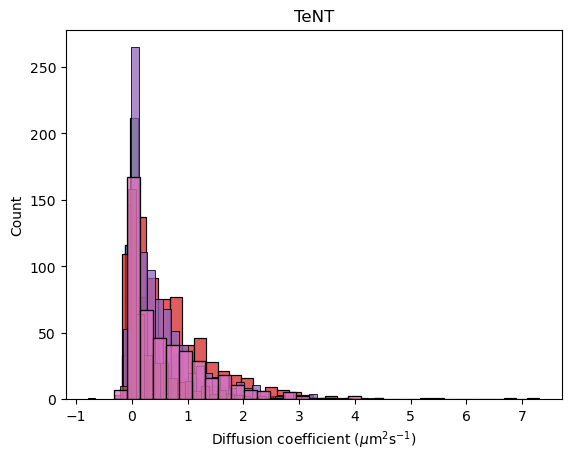

In [711]:
histplot_group('/Users/lizakozlikina/Desktop/NOSOV dSTORM/SPT/SNAP25/TeNT/snap_tent_dif_coef', 'TeNT')

<Axes: title={'center': 'Control'}, xlabel='Diffusion coefficient ($\\mu$m$^{2}$s$^{-1}$)', ylabel='Count'>

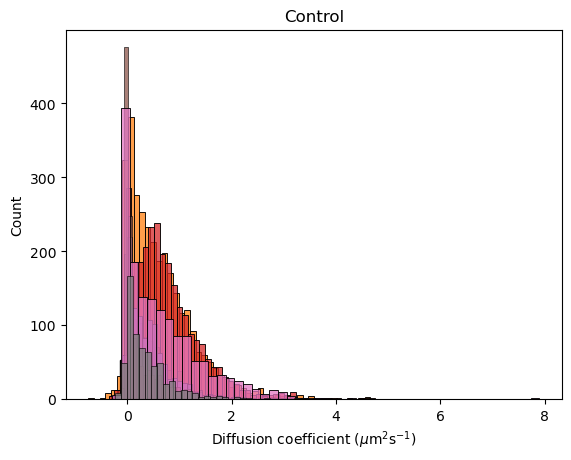

In [713]:
histplot_group('/Users/lizakozlikina/Desktop/NOSOV dSTORM/SPT/SNAP25/TeNT Control/snap_tent_control_dif_coef', 'Control')


# Find negative values and sort two tables

In [360]:
negative_slope = df_traj.columns[(df_traj < 0).any()].tolist()

## Initial code

In [ ]:
df = df.rename(columns = {'POSITION_X' : 'X', 'POSITION_Y' : 'Y'})
df['X'] = pd.to_numeric(df['X'], errors='coerce')
df['Y'] = pd.to_numeric(df['Y'], errors='coerce')
df = df.dropna(subset=['X', 'Y'])
# Extract unique track IDs and their corresponding indices
id = df['TRACK_ID'].unique()

# Precompute trajectories
traj = [np.column_stack((
        df.loc[df['TRACK_ID'] == track_id, 'X'].values, 
        df.loc[df['TRACK_ID'] == track_id, 'Y'].values)) 
    for track_id in id]

# Initialize results
displacements_all = []
mean_displacements = []
std_displacements = []
SD_all = []
MSD_all = []
stdMSD_all = []

# Compute displacements and related statistics
for Traj in traj:
    X, Y = Traj[:, 0], Traj[:, 1]
    Length = len(Traj)

    displacements = []
    mean_displacement = []
    std_displacement = []
    SD = []
    MSD = []
    stdMSD = []

    for n in range(0, Length):
        # Calculate displacements efficiently
        delta_X = X[n:] - X[:Length - n]
        delta_Y = Y[n:] - Y[:Length - n]
        displacement = np.sqrt(delta_X**2 + delta_Y**2)
        
        displacements.append(displacement)
        mean_displacement.append(np.mean(displacement))
        std_displacement.append(np.std(displacement))
        SD_n = displacement**2
        SD.append(SD_n)
        MSD.append(np.mean(SD_n))
        stdMSD.append(np.std(SD_n))

    displacements_all.append(displacements)
    mean_displacements.append(mean_displacement)
    std_displacements.append(std_displacement)
    SD_all.append(SD)
    MSD_all.append(MSD)
    stdMSD_all.append(stdMSD)

# Calculate MSD track slopes
length = len(MSD_all)
x = [0.02,0.03,0.04]
MSD_track = []
msd = pd.DataFrame(columns = ['msd', 't'])
for i in range(0, length):
    track = MSD_all[i]
    y = np.array(track[2:5])
    msd['msd'].insert(y)
    msd['t'].append(x)
    
    p = np.polyfit(x, y, 1)
    MSD_track.append(p[0])
msd_df = pd.DataFrame(msd).T

    # x = np.array([0.02, 0.03, 0.04])
# MSD_track = [np.polyfit(x, np.array(MSD[2:5]), 1)[0] for MSD in MSD_all]

In [ ]:
msd_df = pd.DataFrame(msd).T
msd_df.head()

In [ ]:
plt.scatter(x, MSD_all[267][2:5])

In [ ]:
df = pd.DataFrame(columns = ['r', 't'])

vals = [7, 8]
for i, value in enumerate(vals):
    df.at[i, 'r'] = vals

print(df)